In [1]:
!pip3 install vnstock
from vnstock import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

import warnings

warnings.filterwarnings('ignore')

In [5]:
VIB = stock_historical_data(symbol = "VIB", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")


In [6]:
VIB = VIB[['Close']]
VIB

,Close
Time,
2017-06-02,3320
2017-06-05,3290
2017-06-06,3320
2017-06-07,3340
2017-06-08,3310
...,...
2023-12-11,19200
2023-12-12,19200
2023-12-13,19050


In [7]:
VIB['Target'] = VIB.Close.shift(-1)
VIB.dropna(inplace = True)
VIB.head()

,Close,Target
Time,,
2017-06-02,3320,3290.0
2017-06-05,3290,3320.0
2017-06-06,3320,3340.0
2017-06-07,3340,3310.0
2017-06-08,3310,3290.0


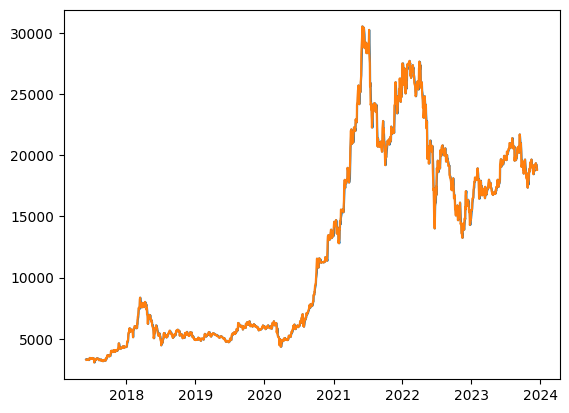

In [8]:
X = VIB[['Close']]
y = VIB[['Target']]

plt.plot(X)
plt.plot(y)
plt.show()

In [9]:
# chia train, test
train_size = int(0.6 * len(VIB))
test_size = len(VIB) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [10]:
# Define the parameter grid
# Define a dictionary 'params' where keys are hyperparameters of the XGBoost model,
# and values are lists of possible values for each hyperparameter
params = {
    'max_depth': [3, 7],
    'learning_rate': [0.05, 0.2],
    'n_estimators': [700, 1000],
    'colsample_bytree': [0.5,1]
}

# Create an XGBRegressor instance
xgbr = XGBRegressor()

# Create a GridSearchCV instance
model = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error',
    verbose=1
)

model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)
print("Lowest RMSE:", (-model.best_score_)**(1/2.0))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE: 3242.744485290813


In [11]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000,colsample_bytree=0.5, learning_rate=0.05, max_depth=3)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1,1)
print(len(y_pred))
print(len(y_test))

654
654


In [13]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
msle = mean_squared_log_error(y_test, y_pred)

print("MAPE:", mape)
print("MAE: ",  mae)
print("RMSE:", rmse)
print("MSLE: ", msle)

MAPE: 3.4804249895774984
MAE:  762.677698537844
RMSE: Target    1153.544558
dtype: float64
MSLE:  0.0023686324113204944


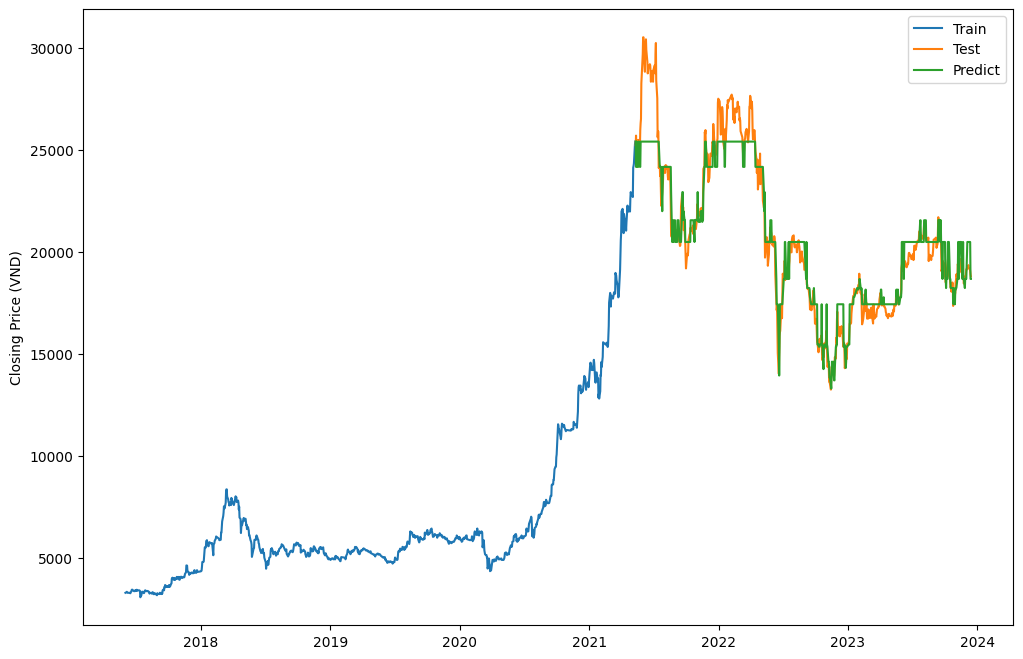

In [14]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred, label='Predict')
plt.ylabel('Closing Price (VND)')
plt.legend()
plt.show()

In [16]:
# lấy giá trị Close của ngày cuối cùng trong dataset
last_row = VIB.tail(1)
last_data = last_row['Close'].values.reshape(-1,1)
last_data

array([[18900]])

In [17]:
# tạo mảng chứa giá trị predict của 60 ngày tiếp theo
x_next_60_days = []

# predict giá Close 60 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(60):
    x_pred_next = model.predict(last_data)
    x_next_60_days.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)
print("Kết quả dự đoán :", x_next_60_days)


Kết quả dự đoán : [array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float32), array([18674.64], dtype=float

In [18]:
x_next_60_days = np.array(x_next_60_days)
x_next_60_days.reshape(-1,1)

array([[18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [18674.64],
       [1867

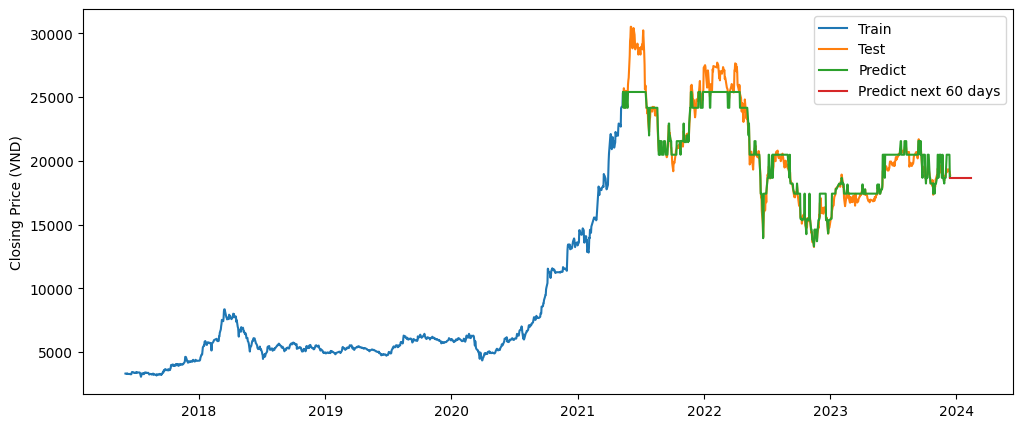

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_test, y_pred, and x_next_7_days are defined

plt.figure(figsize=(12, 5))
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(X_test.index, y_pred, label='Predict')


last_date = X_test.index[-1]
next_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')
plt.plot(next_dates, x_next_60_days, label='Predict next 60 days')

plt.ylabel('Closing Price (VND)')
plt.legend()
plt.show()
